# USS assets 
## historic growth 1992-2021 
## forecast growth from discount rates 2011, 14, 17, 20 and 21

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
path_base = '../data/'
path_assets = path_base + 'assets_returns/'
path_cpi = path_base + 'cpi_gilts/'
path_discount = path_base + 'discount_rates/'
path_ons = path_base + 'ons/'

BASE_YEAR=2020

### Load data

In [5]:
# Historic CPI, from ONS
cpi_ons = np.genfromtxt(path_ons + 'cpi_ons_derived_for_graph_ussbriefs106.csv', delimiter=',', usecols=(0,3), skip_header=1)

# Historic USS assets and investment growth
assets_nom = np.genfromtxt(path_assets + 'nominal/1992_2021_assets_nominal.csv', delimiter=',', usecols=(0,1), skip_header=1, dtype=float)
inv_ret_nom = np.genfromtxt(path_assets + 'nominal/1987_2021_investment_returns_nominal.csv', delimiter=',', usecols=(0,1), skip_header=1, dtype=float)

# Future discount rates, assume column 0 is year, column 1 is term, column 2 is discount rate
# Should really compute from term to be derived more directly from data
# Should really load from original data in nominal, and compute from USS projected CPI
disc_2011_cpi = np.genfromtxt(path_discount + 'cpi/2011_DISCOUNT_RATE_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_2014_cpi = np.genfromtxt(path_discount + 'cpi/2014_DISCOUNT_RATE_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_2017a_cpi = np.genfromtxt(path_discount + 'cpi/2017_September_DISCOUNT_RATE_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_2017b_cpi = np.genfromtxt(path_discount + 'cpi/2017_November_DISCOUNT_RATE_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_2018_cpi = np.genfromtxt(path_discount + 'cpi/2018_DISCOUNT_RATE_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_2019_cpi = np.genfromtxt(path_discount + 'cpi/2019_DISCOUNT_RATE_interim_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_2020a_cpi = np.genfromtxt(path_discount + 'cpi/2020_DISCOUNT_RATE_maintain_benefits_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_2020b_cpi = np.genfromtxt(path_discount + 'cpi/2020_DISCOUNT_RATE_UUK_cuts_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_2021a_cpi = np.genfromtxt(path_discount + 'cpi/2021_DISCOUNT_RATE_USS_est_maintain_benefits_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_2021b_cpi = np.genfromtxt(path_discount + 'cpi/2021_DISCOUNT_RATE_USS_est_UUK_cuts_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)

# Put discount rates in a python doctionary for easy access
disc_cpi_dict = { "2011" : disc_2011_cpi,
                "2014" : disc_2014_cpi,
                "2017a" : disc_2017a_cpi,
                "2017b" : disc_2017b_cpi,
                "2018" : disc_2018_cpi,
                "2019" : disc_2019_cpi,
                "2020a" : disc_2020a_cpi,
                "2020b" : disc_2020b_cpi,
                "2021a" : disc_2021a_cpi,
                "2021b" : disc_2021b_cpi}


### General helper functions

In [6]:
def log_interp(z, x, y):
    # Log interpolator - useful for asset values, or other quantities which grow exponentially
    logy = np.log10(y)
    return np.power(10.0, np.interp(z, x, logy, left=np.nan, right=np.nan))

### CPI helper functions

In [7]:
def cum_cpi_ons(base_yr=BASE_YEAR):
    """
    Calculates cumulative CPI index from ONS data, relative to a base year, 
    which defaults to the value specified above in BASE_YEAR
    
    Returns an array of two columns, year and value.
    """
    base_yr_ind = np.where(cpi_ons[:, 0] == base_yr)[0][0]
    cum_cpi = cpi_ons.copy()
    cum_cpi[base_yr_ind,1] = 1.0
    cum_cpi[base_yr_ind+1:, 1] = np.cumprod(1 + cpi_ons[base_yr_ind:-1, 1])
    cum_cpi[base_yr_ind-1::-1, 1] = np.cumprod(1/(1 + cpi_ons[base_yr_ind:0:-1, 1]))

    return cum_cpi

def get_cpi_ons(y):
    """
    Returns ONS CPI in year y, by linear interpolation.
    y can be single number, array, or range.
    
    Returns values with the same shape as y. 
    Years outside the ONS data return a nan.
    """
    return np.interp(y, cpi_ons[:,0], cpi_ons[:,1], left=np.nan, right=np.nan)

def get_cum_cpi_ons(y, base_year=BASE_YEAR):
    """
    Gets ONS cumulative CPI in year y relative to base_year. Fractions of year by geometric interpolation,. 
    y can be single number, array, or range.
    
    Returns values with the same shape as y. 
    Years outside the ONS data return a nan.
    """
    cpi_adj_arr = cum_cpi_ons(base_year)
    return log_interp(y, cpi_adj_arr[:, 0], cpi_adj_arr[:, 1])

## Discount rate helper functions

In [8]:
def cum_disc_uss_cpi(valuation):
    """
    Calculates cumulative discounts forward from a given valuation date, 
    using USS data.
    Allowed values for valuation = "2011", "2014", "2017a", "2017b" 
    "2018", "2019", "2020a", "2020b", "2021a", "2021b") to be implemented
        
    Returns an array of two columns, year and value.
    """
    disc = disc_cpi_dict[valuation]
    cum_disc = disc.copy()
    cum_disc[:, 1] = np.cumprod(1/(1 + disc[:, 1]))
    return cum_disc

def get_cum_disc_uss_cpi(y, valuation):
    """
    Get USS cumulative discounts in year y, by geometric interpolation, relative to year of valuation.
    y can be single number, array, or range.
    
    Returns values with the same shape as y. 
    Years outside the ONS data return a nan.
    """
    disc_arr = cum_disc_uss_cpi(valuation)
    return log_interp(y, disc_arr[:, 0], disc_arr[:, 1])


## Assets and investment return helper functions

In [9]:
# Transform investment returns from nominal to CPI
inv_ret_cpi = inv_ret_nom.copy()
inv_ret_cpi[:,1] = inv_ret_nom[:, 1] - get_cpi_ons(inv_ret_nom[:, 0])

def cum_inv_ret_cpi(base_yr=BASE_YEAR):
    """
    Calculate cumulative investment returns, from CPI-adjusted  
    nominal investment returns.
    
    Returns an array of two columns, year and value.
    """
    base_yr_ind = np.where(inv_ret_cpi[:, 0] == base_yr)[0][0]
    cum_inv_ret_cpi = inv_ret_cpi.copy()
    cum_inv_ret_cpi[base_yr_ind,1] = 1.0
    cum_inv_ret_cpi[base_yr_ind+1:, 1] = np.cumprod(1 + inv_ret_cpi[base_yr_ind+1:, 1])
    cum_inv_ret_cpi[base_yr_ind-1::-1, 1] = np.cumprod(1/(1 + inv_ret_cpi[base_yr_ind:0:-1, 1]))

    return cum_inv_ret_cpi

def get_cum_inv_ret_cpi(y, base_yr=BASE_YEAR):
    """
    Get cumulatuve investment returns for any set of years y, with linear interpolation 
    for fractional years.
    
    Returns values with the same shape as y. 
    Years outside the ONS CPI data return a nan.
    """
    cum_inv_ret_arr = cum_inv_ret_cpi(base_yr)
    return log_interp(y, cum_inv_ret_arr[:, 0], cum_inv_ret_arr[:, 1])

def get_assets_cpi_reported(y, base_year=BASE_YEAR):
    """
    Get value of assets reported in USS annual statements for set of years y.
    
    Returns a two-column array of years y and values.
    """
    if hasattr(y, '__iter__'):
        len_y = len(y)
    else:
        len_y = 1
    assets_cpi = np.ones((len_y, 2))
    assets_cpi[:,0] = y
    assets_cpi[:,1] = np.interp(y, assets_nom[:, 0], assets_nom[:, 1]) / get_cum_cpi_ons(y, base_year)    
    return assets_cpi

def get_assets_cpi_inv_ret(y, base_year=BASE_YEAR):
    """
    Get value of assets calculated from investment returns in USS annual statements, 
    for set of years y.
    
    Returns a two-column array of years y and values
    """
    if hasattr(y, '__iter__'):
        len_y = len(y)
    else:
        len_y = 1
    assets_base = get_assets_cpi_reported(base_year)[0][1]
    assets_cpi = np.ones((len_y, 2))
    assets_cpi[:,0] = y
    assets_cpi[:,1] = assets_base * get_cum_inv_ret_cpi(y, base_year)
    return assets_cpi


In [12]:
# Construct estimates of investment assets
assets_cpi_2020 = get_assets_cpi_reported(assets_nom[:,0])
assets_cpi_inv_ret_2020 = get_assets_cpi_inv_ret(assets_nom[:,0])

In [13]:
# Assemble dictionary of projected assets estimated from USS prudent discount rates
end_year = 2068
proj_assets_cpi_2020 = {}

proj_assets_cpi_2020["2011"] = get_assets_cpi_reported(2011)[0,1]/get_cum_disc_uss_cpi(range(2012, end_year), "2011")
proj_assets_cpi_2020["2014"] = get_assets_cpi_reported(2014)[0,1]/get_cum_disc_uss_cpi(range(2015, end_year), "2014")
proj_assets_cpi_2020["2017b"] = get_assets_cpi_reported(2017)[0,1]/get_cum_disc_uss_cpi(range(2018, end_year), "2017b")
proj_assets_cpi_2020["2018"] = get_assets_cpi_reported(2018)[0,1]/get_cum_disc_uss_cpi(range(2019, end_year), "2018")
proj_assets_cpi_2020["2020a"] = get_assets_cpi_reported(2020)[0,1]/get_cum_disc_uss_cpi(range(2021, end_year), "2020a")
proj_assets_cpi_2020["2021a"] = get_assets_cpi_reported(2021)[0,1]/get_cum_disc_uss_cpi(range(2022, end_year), "2021a")


### Plotting

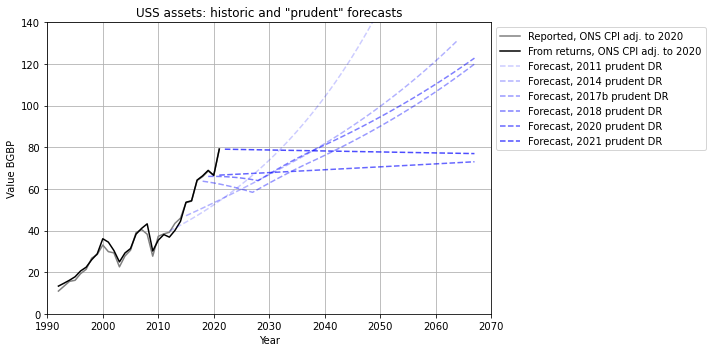

In [15]:
plt.figure(figsize=(10,5))

plt.plot(assets_cpi_2020[:,0], assets_cpi_2020[:,1], 
         color=(0.5,0.5,0.5), 
         label='Reported, ONS CPI adj. to 2020')

plt.plot(assets_cpi_inv_ret_2020[:,0], assets_cpi_inv_ret_2020[:,1], 
         color='k', 
         label='From returns, ONS CPI adj. to 2020')

plt.plot(range(2012, end_year), proj_assets_cpi_2020["2011"], 
         color='b', ls='--', alpha=0.2, label='Forecast, 2011 prudent DR')
plt.plot(range(2015, end_year), proj_assets_cpi_2020["2014"], 
         color='b', ls='--', alpha=0.3, label='Forecast, 2014 prudent DR')
plt.plot(range(2018, end_year), proj_assets_cpi_2020["2017b"], 
         color='b', ls='--', alpha=0.4, label='Forecast, 2017b prudent DR')
plt.plot(range(2019, end_year), proj_assets_cpi_2020["2018"], 
         color='b', ls='--', alpha=0.5, label='Forecast, 2018 prudent DR')
plt.plot(range(2021, end_year), proj_assets_cpi_2020["2020a"], 
         color='b', ls='--', alpha=0.6, label='Forecast, 2020 prudent DR')
plt.plot(range(2022, end_year), proj_assets_cpi_2020["2021a"], 
         color='b', ls='--', alpha=0.7, label='Forecast, 2021 prudent DR')

plt.xlim(1990,2070)
plt.ylim(0,140)

plt.title('USS assets: historic and "prudent" forecasts')
plt.xlabel('Year')
plt.ylabel('Value BGBP')

plt.grid()
plt.legend(bbox_to_anchor=(1.0, 0.0, .1, 1))

plt.tight_layout()
plt.savefig("uss_assets_and_prudent_forecasts.pdf")